# 02. Classification

Understanding basics of classifications and then jumping to scikit-learn

## The Iris dataset
* sepal length (pl: działka kielicha)
* sepal width
* petal length (pl: płatek)
* petal width  

**Features** - individual numeric measurements to describe data.
This dataset has *four* feautures.

The problem:
> Given these examples, if we see a new flower out in the field, could we make a good prediction about its species from its features?

This is **supervised learning** 


In [21]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.datasets import load_iris

data = load_iris()

print(data.data[:5])
print("Unique targets %d " % np.unique(data.target).size)

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]]
Unique targets 3 


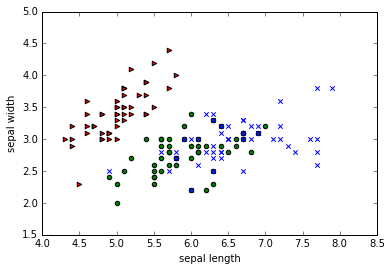

In [28]:
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names

markers = {0:'>', 1:'o', 2:'x'}
colors  = {0:'r', 1:'g', 2:'b'}

plt.xlabel("sepal length")
plt.ylabel("sepal width")

for i in range(3):
    plt.scatter(features[target == i, 0],
                features[target == i, 1],
                marker=markers[i],
                c=colors[i])

In [30]:
# Building first classification model:
labels = target_names[target]

# Petal length is the feature at position 2
plength = features[:, 2]

# Build an array of booleans:
is_setosa = (labels == 'setosa')

max_setosa = plength[is_setosa].max()
min_non_setosa = plength[~is_setosa].min()

print('Maximum of setosa: {0}.'.format(max_setosa))
print('Minimum of others: {0}.'.format(min_non_setosa))

Maximum of setosa: 1.9.
Minimum of others: 3.0.


In [31]:
features = features[~is_setosa]
labels = labels[~is_setosa]

is_virginica = (labels == 'virginica')

In [32]:
best_acc = -1.0
for fi in range(features.shape[1]):
    # Testing all possible thresholds
    thresh = features[:, fi]
    for t in thresh:
        # Get the vector for feature 'fi'
        feature_i = features[:, fi]
        # apply threshold 't'
        pred = (feature_i > t)
        acc = (pred == is_virginica).mean()
        rev_acc = (pred == ~is_virginica).mean()
        
        reverse = rev_acc > acc
        
        if reverse:
            acc = rev_acc
            
        if acc > best_acc:
            best_acc = acc
            best_fi = fi
            best_t = t
            best_reverse = reverse

In [33]:
def is_virginica_test(fi, t, reverse, example):
    test = example[fi] > t
    if reverse:
        test = not test
    return test

# Evaluation - holding out data and cross-validation

In [ ]:
correct = 0.0
for ei in range (len(features)):
    # select all but one at position 'ei':
    training = np.ones(len(features), bool)
    training[ei] = False
    testing = ~training
    model = fit_model(features[training], is_virginica[training])
    predictions = predict(model, features[testing])
    correct += np.sum(predictions == is_virginica[testing])
    
acc = correct/float(len(features))
print('Accuracy: {0:.1%}'.format(acc))

^UP - leave one, train everything else, test only one

major problem with leave-one-out cross-validation: perfmorming many times more work

**x-fold cross-validation**

| Dataset | Fold1 | Fold2 | Fold3 | Fold4 | Fold5 |
|---------|-------|-------|-------|-------|-------|
| 1       | Test  | train | train | train | train |
| 2       | train | Test  | train | train | train |
| 3       | train | train | Test  | train | train |
| 4       | train | train | train | Test  | train |
| 5       | train | train | train | train | Test  |

Split dataset into five pieces. One block is for testing others are for training.

If you have little data, you can even consider using 10 or 20 folds.

When generating the folds you need to be careful to keep them balanced (scikit does it for us)

One problem - we created several models. What do we return? Train a single overall model on all your data. X-validation gives estimate of how well this model werks.

# Builiding more complex classifiers

"What makes up a classification model?"

- **The structure of the model** - how will model make decisions
- **The search procedure**
- **The gain or loss function**  - some mistakes might be costlier

## A more complex dataset and a more complex classifier

### Learning about the Seeds dataset

Dataset of measurements of wheat seeds. Seven features that are present:
- Area A 
- Permieter P
- compactness C = 4*pi*A/(P^2)
- length of kernel
- width of kernel
- asymmetry coefficent
- length of kernel groove

**Feature engineering** - trying to create new features (often matters more for performance). just like in example above - compactness is function of A, P

## Nearest neighbor classification

The scikit-learn classification API is organized around classifier objects.
- `fit(features, labels)`
- `predict(features)`

In [59]:
def load_dataset(dataset_name):
    '''
    data,labels = load_dataset(dataset_name)
    Load a given dataset
    Returns
    -------
    data : numpy ndarray
    labels : list of str
    '''
    data = []
    labels = []
    with open('data/{0}.tsv'.format(dataset_name)) as ifile:
        for line in ifile:
            tokens = line.strip().split('\t')
            data.append([float(tk) for tk in tokens[:-1]])
            labels.append(tokens[-1])
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [68]:
from sklearn.neighbors import KNeighborsClassifier

features, labels = load_dataset('seeds')


# In constructor we specify the number of neighbors to consider
classifier = KNeighborsClassifier(n_neighbors=1)

# cross-validation
from sklearn.cross_validation import KFold

kf = KFold(len(features), n_folds=5, shuffle=True)
# `means` will be a list for mean accuracies per fold
means = []
for training,testing in kf:
    classifier.fit(features[training], labels[training])
    prediction = classifier.predict(features[testing])
    
    # np.mean on an array of booleans returns fraction
    # of correct decisions for this fold:
    curmean = np.mean(prediction == labels[testing])
    means.append(curmean)

print("Mean accuracy: {:.1%}".format(np.mean(means)))

Mean accuracy: 90.0%


45 page in book, red flags!

*normalize to z-scores*
`f' = (f - u) / o`
f - old feature
u - mean of the feature
o - standard deviation

Pipeline constructor takes a list of pairs(str,clf).
the first element is a string naming the step, while the second one is the object that performs the transformation.

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors=1)
classifier = Pipeline([('norm', StandardScaler()),
                      ('knn', classifier)])

After normalization, every feature is in the same units.
> while a few dimensions are dominant in the original data,
after normalization, they are all given the same importance.


# END OF MY NOTES, PASTING code from book's github repo:
https://github.com/luispedro/BuildingMachineLearningSystemsWithPython/blob/master/ch02/load.py

**it's part about normalizing data and RED FLAG when visualizing data**

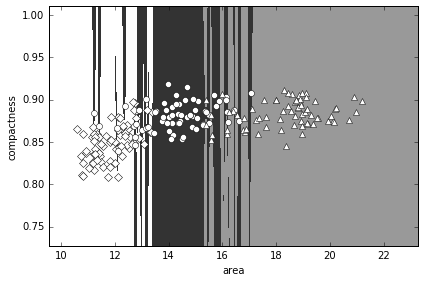

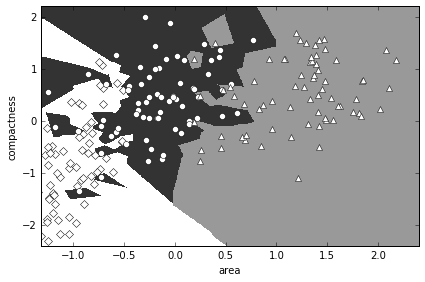

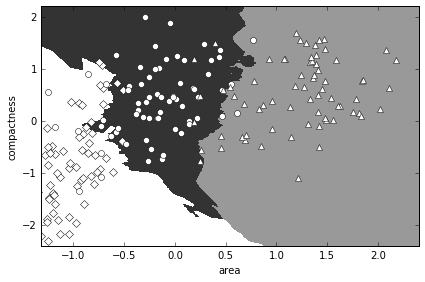

In [77]:
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

COLOUR_FIGURE = False

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]


def plot_decision(features, labels, num_neighbors=1):
    '''Plots decision boundary for KNN
    Parameters
    ----------
    features : ndarray
    labels : sequence
    Returns
    -------
    fig : Matplotlib Figure
    ax  : Matplotlib Axes
    '''
    y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
    x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
    X = np.linspace(x0, x1, 1000)
    Y = np.linspace(y0, y1, 1000)
    X, Y = np.meshgrid(X, Y)

    model = KNeighborsClassifier(num_neighbors)
    model.fit(features[:, (0,2)], labels)
    C = model.predict(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    if COLOUR_FIGURE:
        cmap = ListedColormap([(1., .7, .7), (.7, 1., .7), (.7, .7, 1.)])
    else:
        cmap = ListedColormap([(1., 1., 1.), (.2, .2, .2), (.6, .6, .6)])
    fig,ax = plt.subplots()
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[2])
    ax.pcolormesh(X, Y, C, cmap=cmap)
    if COLOUR_FIGURE:
        cmap = ListedColormap([(1., .0, .0), (.1, .6, .1), (.0, .0, 1.)])
        ax.scatter(features[:, 0], features[:, 2], c=labels, cmap=cmap)
    else:
        for lab, ma in zip(range(3), "Do^"):
            ax.plot(features[labels == lab, 0], features[
                     labels == lab, 2], ma, c=(1., 1., 1.), ms=6)
    return fig,ax


features, labels = load_dataset('seeds')
names = sorted(set(labels))
labels = np.array([names.index(ell) for ell in labels])

fig,ax = plot_decision(features, labels)
fig.tight_layout()

features -= features.mean(0)
features /= features.std(0)
fig,ax = plot_decision(features, labels)
fig.tight_layout()

fig,ax = plot_decision(features, labels, 11)
fig.tight_layout()